In [484]:
import os
import copy
import numpy as np
import pandas as pd
import getpass
import cPickle as pickle
import pylab as plt
%matplotlib inline
import GPy
import itertools
import random

datasets = '/home/'+ getpass.getuser() +'/Datasets/'
print datasets

file_name = 'tasks_by_skills_v3.p'
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks', file_name)
with open(p, 'r') as f:
    data = pickle.load(f)
(X, test, y) = data

file_name = 'tasks_by_skills_v3_o.p'
p = os.path.join(datasets, 'FoEmployment/Analysis_of_ONET_Tasks', file_name)
with open(p, 'r') as f:
    data_o = pickle.load(f)
(X_o, test_o, y_o) = data_o

#Misc settings
ms = 11  # marker size in plots
random.seed =  6   # random seed

/home/scpd/Datasets/


In [4]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [5]:
def learn_a_GP(x_train, y_train):
    in_dims = x_train.shape[1]
    
    k1 = GPy.kern.RBF(in_dims, variance=1, lengthscale=0.4)
    k2 = GPy.kern.Matern32(in_dims, 0.5, 0.2)
    # Sum of kernels
    k = k1 + k2
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()
    return m

In [6]:
val_size = 0.10
cols = test.columns[2:]
in_dims = cols.shape[0]

# Create a Validation set
msk = [i for i in range(X.shape[0])]

In [8]:
# # Investigate which combination of standard Kernels explains the data best:
n_validation_set = int(np.floor(X.shape[0]*val_size))
print "Val set: ", msk[:n_validation_set]
# random.shuffle(msk)

x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

x_test = test[cols].as_matrix()
kerns = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), GPy.kern.MLP(in_dims), 
         GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

models, errs = [], []
print "\nSingle Kernels: "
for cnt, k in enumerate(kerns):
    print cnt
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()    
    models.append(m)
    y_pred, Vp = m.predict(x_valid, full_cov=False)
    err = rmse(y_valid, y_pred)
    errs.append(err)
    print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rmse(y_valid, np.mean(y_valid)), m.objective_function()) 

print "\nSum/Multiply Kernels: "
for cnt, (i, j) in enumerate(itertools.combinations_with_replacement(kerns, 2)):
    for sum_or_mult in [0,1]:
        if sum_or_mult:
            m = GPy.models.GPRegression(x_train, y_train, i+j)
        else:
            if i==j: continue
            m = GPy.models.GPRegression(x_train, y_train, i*j)
        m.optimize()    
        models.append(m)
        y_pred, Vp = m.predict(x_valid, full_cov=False)
        err = rmse(y_valid, y_pred)
        errs.append(err)
        rand_err = rmse(y_valid, np.mean(y_valid))
        print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rand_err, m.objective_function()) 

print "\nBest:"   
print errs[np.argmin(errs)]
print models[np.argmin(errs)]

 Val set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Single Kernels: 
0
RMS Error is: 0.517 vs 0.626. -LLhood = -264.38862128
1
RMS Error is: 0.498 vs 0.626. -LLhood = -263.466360923
2
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284687681
3
RMS Error is: 0.463 vs 0.626. -LLhood = -230.945809578
4
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115197469
5
RMS Error is: 0.627 vs 0.626. -LLhood = -281.944246555

Sum/Multiply Kernels: 
RMS Error is: 0.517 vs 0.626. -LLhood = -264.38862128
RMS Error is: 0.499 vs 0.626. -LLhood = -263.405767296
RMS Error is: 0.495 vs 0.626. -LLhood = -263.419413873
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284693102


 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/paramz-0.7.3-py2.7.egg/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1


RMS Error is: 0.512 vs 0.626. -LLhood = -263.222722568
RMS Error is: 0.463 vs 0.626. -LLhood = -230.945428964
RMS Error is: 0.462 vs 0.626. -LLhood = -230.366112385
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115104657
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115347923
RMS Error is: 0.627 vs 0.626. -LLhood = -281.883285648
RMS Error is: 0.627 vs 0.626. -LLhood = -281.883294694
RMS Error is: 0.498 vs 0.626. -LLhood = -263.46636093
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284785936
RMS Error is: 0.512 vs 0.626. -LLhood = -263.222816169
RMS Error is: 0.463 vs 0.626. -LLhood = -230.942445786
RMS Error is: 0.463 vs 0.626. -LLhood = -230.351049101
RMS Error is: 0.515 vs 0.626. -LLhood = -266.113450321
RMS Error is: 0.515 vs 0.626. -LLhood = -266.115348439
RMS Error is: 0.480 vs 0.626. -LLhood = -270.375886132
RMS Error is: 0.498 vs 0.626. -LLhood = -263.466360924
RMS Error is: 0.509 vs 0.626. -LLhood = -263.284687678
RMS Error is: 0.463 vs 0.626. -LLhood = -230.942093627
RMS Error i

 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in square
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:invalid value encountered in multiply


RMS Error is: 0.496 vs 0.626. -LLhood = -269.800797513
RMS Error is: 0.512 vs 0.626. -LLhood = -263.222717027
RMS Error is: 0.463 vs 0.626. -LLhood = -230.945809583
RMS Error is: 0.463 vs 0.626. -LLhood = -230.945115366
RMS Error is: 0.462 vs 0.626. -LLhood = -230.361647147
RMS Error is: 0.463 vs 0.626. -LLhood = -230.94580958
RMS Error is: 0.462 vs 0.626. -LLhood = -230.367930442
RMS Error is: 0.515 vs 0.626. -LLhood = -268.806284639
RMS Error is: 0.515 vs 0.626. -LLhood = -268.806481777
RMS Error is: 0.515 vs 0.626. -LLhood = -268.806161924
RMS Error is: 0.627 vs 0.626. -LLhood = -281.944246548

Best:
0.461638828713

Name : GP regression
Objective : 230.367930442
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.mlp.variance         |       1.81953987674  |      +ve      |        
  sum.mlp.weight_variance  |        5715561.8404  |      +ve      |        
  sum.ml

In [9]:
kers = ['RBF', 'Mat32', 'Mat52', 'MLP', 'Exp', 'Bias']
labels = copy.copy(kers)
for cnt, (i, j) in enumerate(itertools.combinations_with_replacement(kers, 2)):   
    labels.append("%s + %s" %(i, j))
    if i==j: continue
    labels.append("%s x %s" %(i, j))

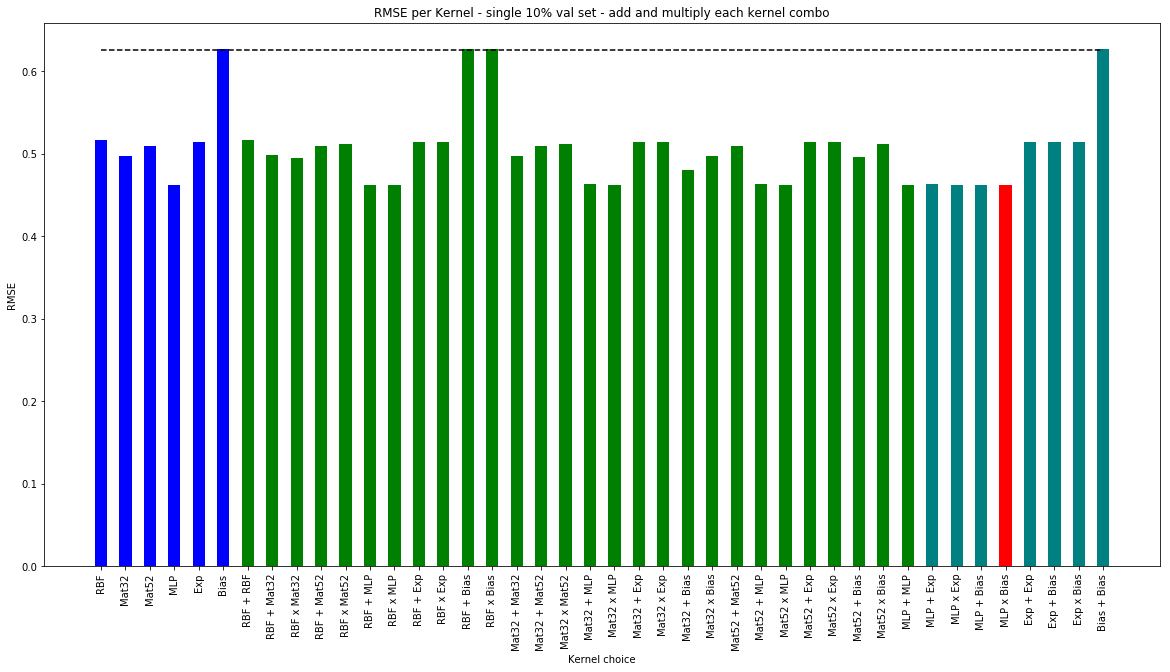

In [10]:
x = range(len(errs))
best_ind = np.argmin(errs)
colours = ["blue"]*len(kers) + ["green"]*28 + ["teal"]*21 
colours[best_ind] = "red" 
fig = plt.figure(figsize=(20,10))

plt.bar(x, errs, 0.5, color = colours)
plt.xticks(x, labels, rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('Kernel choice')
plt.title('RMSE per Kernel - single 10% val set - add and multiply each kernel combo')

# horizontal line indicating the average
plt.plot([0, x[-1]], [rand_err, rand_err], "k--")
plt.show()

# Further investigate the MLP Kernel: 

$$k(x,y) = \sigma^{2}\frac{2}{\pi }  \text{asin} \left ( \frac{ \sigma_w^2 x^\top y+\sigma_b^2}{\sqrt{\sigma_w^2x^\top x + \sigma_b^2 + 1}\sqrt{\sigma_w^2 y^\top y \sigma_b^2 +1}} \right )$$


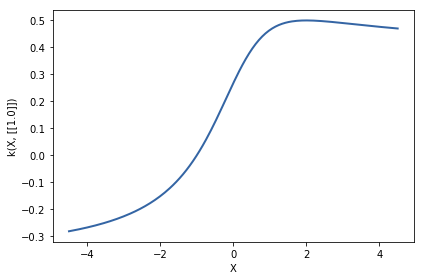

In [482]:
k = GPy.kern.MLP(1)+GPy.kern.Linear(1,variances=1e-100)
k.plot()

In [11]:
# # Investigate which combination of standard Kernels explains the data best:
n_validation_set = int(np.floor(X.shape[0]*val_size))
print "Val set: ", msk[:n_validation_set]
# random.shuffle(msk)

x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)
x_test = test[cols].as_matrix()

kerns = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), GPy.kern.MLP(in_dims), 
         GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

mlp_kers = ['RBF', 'Mat32', 'Mat52', 'Exp', 'Bias']  # Join MLP to these kernels
MLP_kers = [GPy.kern.RBF(in_dims), GPy.kern.Matern32(in_dims), GPy.kern.Matern52(in_dims), 
            GPy.kern.Exponential(in_dims), GPy.kern.Bias(in_dims)]

models, errs = [], []

for fix_h_noise in [0, 1]:  # Optimised vs Fixed (random) Hetro Noise
    
    print "\nSingle Kernels: "
    for cnt, k in enumerate(kerns):
        print cnt, 
        m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, k)
        if fix_h_noise: m.het_Gauss.variance.fix() #Fix the noise term
        m.optimize()    
        models.append(m)
        y_pred, Vp = m._raw_predict(x_valid)
        err = rmse(y_valid, y_pred)
        errs.append(err)
        print "RMS Error is: %0.3f vs %0.3f. %s" % (err, rmse(y_valid, np.mean(y_valid)), m.objective_function()) 

    print "\nSum/Multiply Kernels: "
    for cnt, j in enumerate(MLP_kers):
        for sum_or_mult in [0,1]:
            if sum_or_mult:
                m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, GPy.kern.MLP(in_dims)+j)
            else:
                m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, GPy.kern.MLP(in_dims)*j)   
            if fix_h_noise: m.het_Gauss.variance.fix() #Fix the noise term
            m.optimize()    
            models.append(m)
            y_pred, Vp = m._raw_predict(x_valid)
            err = rmse(y_valid, y_pred)
            errs.append(err)
            rand_err = rmse(y_valid, np.mean(y_valid))
            print "RMS Error is: %0.3f vs %0.3f. -LLhood = -%s" % (err, rand_err, m.objective_function())         
    
print "\nBest:"   
print errs[np.argmin(errs)]
print models[np.argmin(errs)]

Val set:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Single Kernels: 
0 RMS Error is: 0.606 vs 0.626. -LLhood = -92.4752876851
1 RMS Error is: 0.609 vs 0.626. -LLhood = -100.200617325
2 RMS Error is: 0.627 vs 0.626. -LLhood = -95.7374658417
3 RMS Error is: 0.534 vs 0.626. -LLhood = -94.5945411384
4 RMS Error is: 0.603 vs 0.626. -LLhood = -123.244518606
5 RMS Error is: 0.626 vs 0.626. -LLhood = -107.976230915

Sum/Multiply Kernels: 
RMS Error is: 0.541 vs 0.626. -LLhood = -95.536972039
RMS Error is: 0.577 vs 0.626. -LLhood = -86.6303562231
RMS Error is: 0.550 vs 0.626. -LLhood = -96.6552492773
RMS Error is: 0.577 vs 0.626. -LLhood = -86.6307852109
RMS Error is: 0.543 vs 0.626. -LLhood = -94.7701511702
RMS Error is: 0.577 vs 0.626. -LLhood = -86.6303093864
RMS Error is: 0.563 vs 0.626. -LLhood = -116.213744108
RMS Error is: 0.573 vs 0.626. -LLhood = -86.946044756
RMS Error is: 0.553 vs 0.626. -LLhood = -89.089277448

 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in divide
 /home/scpd/Software/anaconda3/envs/gpflow_env/lib/python2.7/site-packages/GPy/kern/src/stationary.py:482: RuntimeWarning:overflow encountered in multiply


 RMS Error is: 0.616 vs 0.626. -LLhood = -322.588199204
3 RMS Error is: 0.598 vs 0.626. -LLhood = -322.108695091
4 RMS Error is: 0.622 vs 0.626. -LLhood = -322.921888529
5 RMS Error is: 0.627 vs 0.626. -LLhood = -323.105324237

Sum/Multiply Kernels: 
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212842518
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558261289
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212841728
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558254471
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212842596
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558261968
RMS Error is: 0.490 vs 0.626. -LLhood = -320.212914427
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558442076
RMS Error is: 0.598 vs 0.626. -LLhood = -322.108695164
RMS Error is: 0.514 vs 0.626. -LLhood = -317.558269979

Best:
0.489838488262

Name : gp
Objective : 320.212841728
Number of Parameters : 288
Number of Optimization Parameters : 5
Updates : True
Parameters:
  gp.                      |             value  

In [12]:
labels = []
for fix_h_noise in [0, 1]:
    l = ""
    if fix_h_noise: l = "_f" 
    for i in kers:
        labels.append(i+l)
    for i in mlp_kers:   
        labels.append("%s + MLP_h%s" %(i, l))
        labels.append("%s x MLP_h%s" %(i, l))

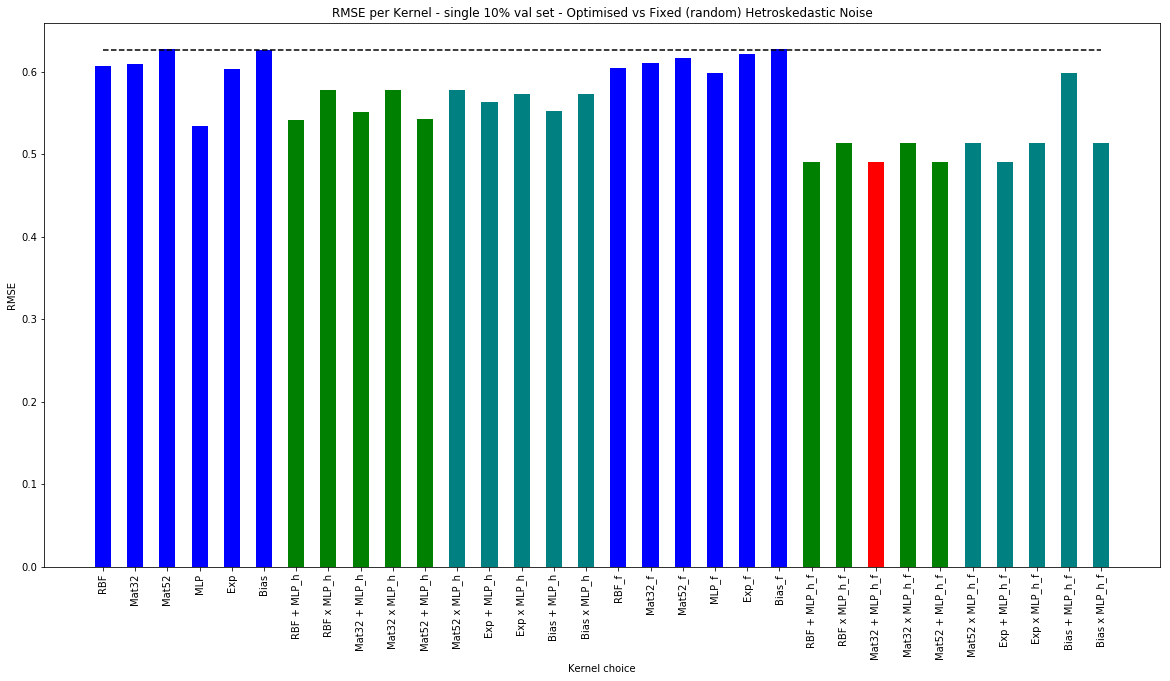

In [13]:
x = range(len(errs))
best_ind = np.argmin(errs)
colours = ["blue"]*len(kers) + ["green"]*len(mlp_kers) + ["teal"]*len(mlp_kers)+["blue"]*len(kers) + ["green"]*len(mlp_kers) + ["teal"]*len(mlp_kers)
colours[best_ind] = "red" 
fig = plt.figure(figsize=(20,10))

plt.bar(x, errs, 0.5, color = colours)
plt.xticks(x, labels, rotation = 90)
plt.ylabel('RMSE')
plt.xlabel('Kernel choice')
plt.title('RMSE per Kernel - single 10% val set - Optimised vs Fixed (random) Hetroskedastic Noise')

# horizontal line indicating the average
plt.plot([0, x[-1]], [rand_err, rand_err], "k--")
plt.show()

##  Average over Repeated Runs

In [376]:
def GPReg_model(k, x_train, y_train, x_valid, y_valid, y_pred):
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()    
    y_pred, Vp = m.predict(x_valid, full_cov=False)
    err = rmse(y_valid, y_pred) 
    return err

def GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, y_pred, fix_noise=True):    
    m = GPy.models.GPHeteroscedasticRegression(x_train, y_train,  k)
    m['.*het_Gauss.variance'] = abs(np.random.normal(0, .2, x_train.shape[0])[:,None])
    if fix_noise: m.het_Gauss.variance.fix() 
    m.optimize()
    y_pred, Vp = m._raw_predict(x_valid)
    err = rmse(y_valid, y_pred)
    return err

def evaluate_models(x_train, y_train, x_valid, y_valid, reg=[], hetro=[], opt_hetro=[]):
    error = []
    in_dims = x_train.shape[1]
    
    list_of_good_kernels = [GPy.kern.MLP(in_dims) + GPy.kern.Bias(in_dims),  #0
              GPy.kern.MLP(in_dims) * GPy.kern.Bias(in_dims),                #1
              GPy.kern.MLP(in_dims) + GPy.kern.RBF(in_dims),                 #2
              GPy.kern.MLP(in_dims) * GPy.kern.RBF(in_dims),                 #3
              GPy.kern.MLP(in_dims) + GPy.kern.Matern32(in_dims),            #4
              GPy.kern.MLP(in_dims) * GPy.kern.Matern32(in_dims),            #5
              GPy.kern.MLP(in_dims) + GPy.kern.Exponential(in_dims),         #6
              GPy.kern.MLP(in_dims) * GPy.kern.Exponential(in_dims)]         #7  
    
    # GP Regression
    for i in reg:
        k = list_of_good_kernels[i]
        error.append(GPReg_model(k, x_train, y_train, x_valid, y_valid, y_pred))
        
    # Hetroscedastic Noise - random
    for i in hetro:
        k = list_of_good_kernels[i]
        error.append(GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, y_pred, True))
        
    # Hetroscedastic Noise - optimised
    for i in opt_hetro:
        k = list_of_good_kernels[i]
        error.append(GPReg_hetro_model(k, x_train, y_train, x_valid, y_valid, y_pred, False))   
    
    # Random Mean assignment:
    error.append(rmse(y_valid, np.mean(y_valid)))
    return error 

all_labels = ["MLP+Bias", "MLPxBias", "MLP+RBF", "MLPxRBF", "MLP+Matern32", "MLPxMatern32", "MLP+Exp", "MLPxExp"]

## Average over many repeated runs 

In [462]:
def plot_bars(RMS_reps, title, labels):
    
    RMS_reps = np.vstack(RMS_reps)
    means = RMS_reps.mean(axis=0)
    stds = RMS_reps.std(axis=0)

    colours = ["teal"]*(len(labels)-1) + ["green"]
    xbar = range(len(means))

    fig, ax = plt.subplots(figsize=(20, 8))
    rects = ax.bar(xbar, means, color = colours,  yerr=stds)
    ax.set_xticks(xbar)
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Average RMSE')
#     ax.set_ylim([0,0.8])
    ax.set_xlabel('Kernel choice')
    ax.set_title(title)
#     autolabel(rects1)
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + 0.2+ rect.get_width()/2., 1.05*height,'%0.3f' % height, ha='center', va='bottom')
    plt.show()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 finished:  24


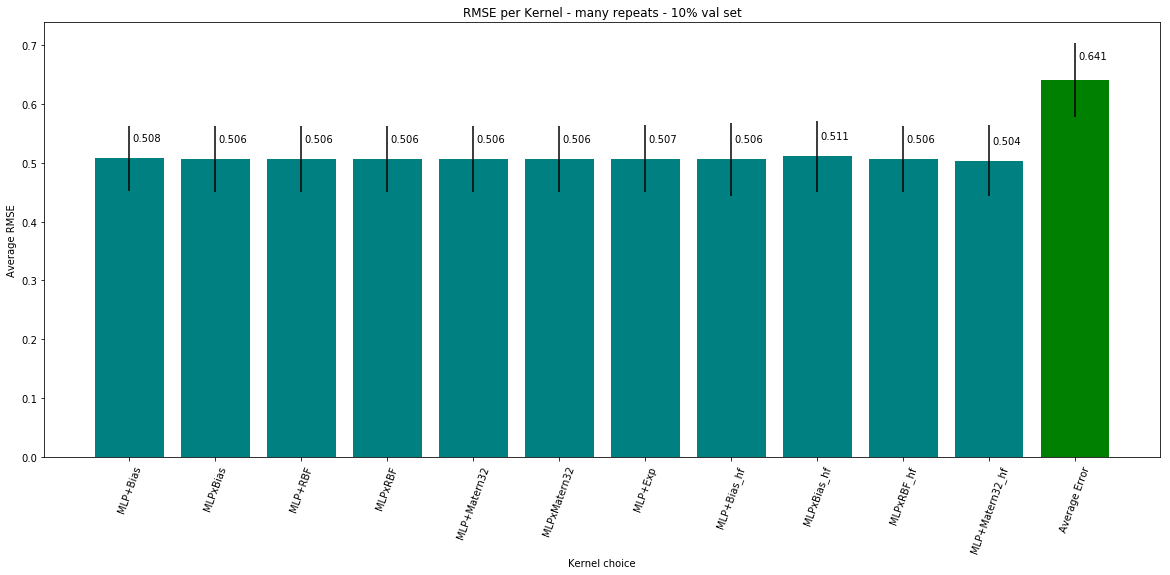

In [461]:
(X, test, y) = data
msk = [i for i in range(X.shape[0])]

RMS_reps = []
n_validation_set = int(np.floor(X.shape[0]*val_size))
for rep in xrange(25):
    print rep, 
    random.shuffle(msk)

    x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
    x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

    y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
    y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    reg = xrange(0,7)
    hetro = [0,1,3,4]
    RMS_reps.append(evaluate_models(x_train, y_train, x_valid, y_valid, reg, hetro))
print "finished: ", rep

labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Average Error"]
plot_bars(RMS_reps, 'RMSE per Kernel - many repeats - 10% val set', labels)


# Replicate with Employment weighted features:

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 finished:  24


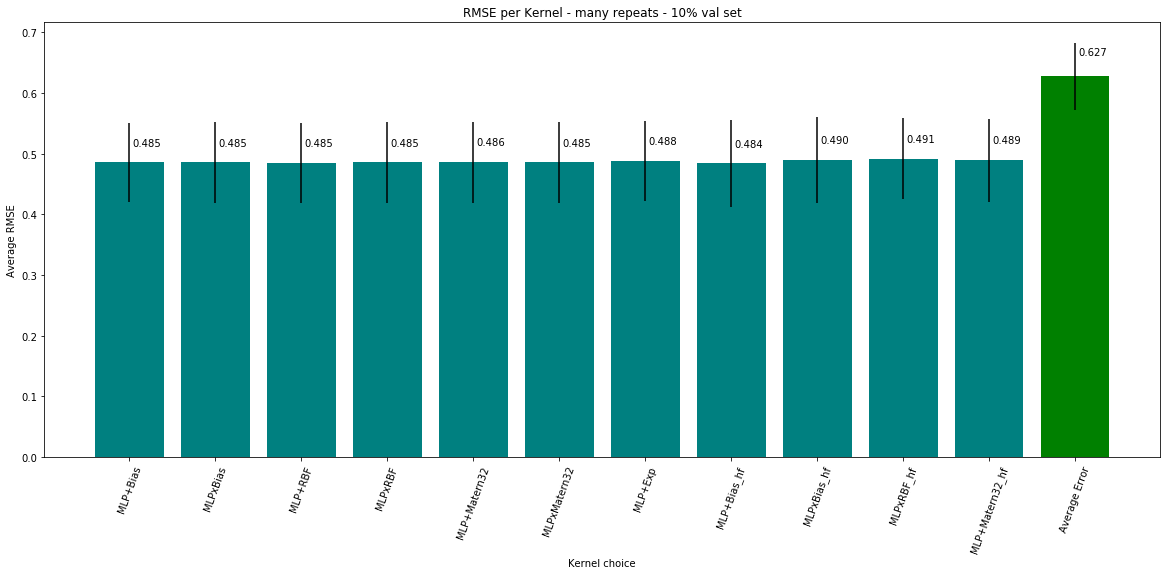

In [485]:
(X, test, y) = data_o
msk = [i for i in range(X.shape[0])]

RMS_reps_o = []
n_validation_set = int(np.floor(X.shape[0]*val_size))
for rep in xrange(25):
    print rep, 
    random.shuffle(msk)

    x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
    x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()

    y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
    y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    reg = xrange(0,7)
    hetro = [0,1,3,4]
    RMS_reps_o.append(evaluate_models(x_train, y_train, x_valid, y_valid, reg, hetro))
print "finished: ", rep
labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Average Error"]
plot_bars(RMS_reps_o, 'RMSE per Kernel - many repeats - 10% val set', labels)


## Investigate ARD Features

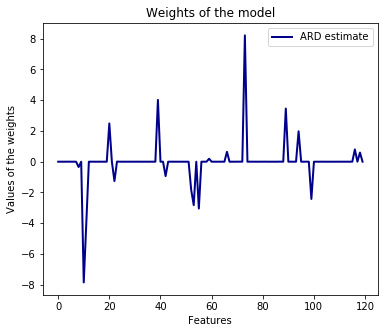

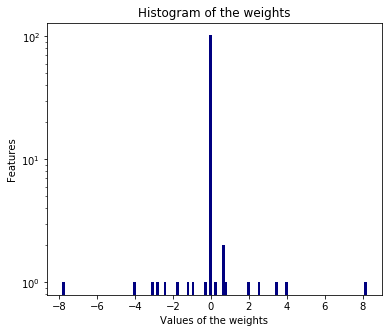

In [48]:
from sklearn.linear_model import ARDRegression
 
# Fit Automatic Relevance Determination Regression
n_samples, n_features = x_train.shape
clf = ARDRegression(compute_score=True)
clf.fit(x_train, y_train)

plt.figure(figsize=(6, 5))
plt.title("Weights of the model")
plt.plot(clf.coef_, color='darkblue', linestyle='-', linewidth=2, label="ARD estimate")
# plt.plot(ols.coef_[0], color='yellowgreen', linestyle=':', linewidth=2, label="OLS estimate")
# plt.plot(w, color='orange', linestyle='-', linewidth=2, label="Ground truth")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.legend(loc=1)

# #############################################################################
# Plot the true weights, the estimated weights, the histogram of the
# weights, and predictions with standard deviations
plt.figure(figsize=(6, 5))
plt.title("Histogram of the weights")
plt.hist(clf.coef_, bins=120, color='navy', log=True)
# plt.scatter(clf.coef_[relevant_features], 5 * np.ones(len(relevant_features)), color='gold', marker='o', label="Relevant features")
plt.ylabel("Features")
plt.xlabel("Values of the weights")
plt.legend(loc=1)

# plt.figure(figsize=(6, 5))
# plt.title("Marginal log-likelihood")
# plt.plot(clf.scores_, color='navy', linewidth=2)
# plt.ylabel("Score")
# plt.xlabel("Iterations")

In [324]:
# USE THE ARD THRESHOLD TO SELECT FEATURES:
threshold = 0.01
category = ["skill"]*35 +["knowledge"]*33+["ability"]*52

# SKILLS, KNOWLEDGE, ABILITIES
print "FEATURES Selected:\n"
b = abs(clf.coef_) > threshold
for cnt, i in enumerate(test.columns[2:]):
    if b[cnt]: 
        print "%0.3f, %s, %s" %(abs(clf.coef_)[cnt], category[cnt], i)


FEATURES Selected:

0.346, skill, Instructing
7.844, skill, Learning Strategies
3.993, skill, Management of Financial Resources
2.485, skill, Persuasion
1.258, skill, Quality Control Analysis
4.015, knowledge, Clerical
0.936, knowledge, Customer and Personal Service
1.815, knowledge, History and Archeology
2.822, knowledge, Law and Government
3.042, knowledge, Mechanical
0.192, knowledge, Physics
0.644, knowledge, Therapy and Counseling
8.208, ability, Depth Perception
3.453, ability, Mathematical Reasoning
1.976, ability, Number Facility
2.421, ability, Peripheral Vision
0.798, ability, Visualization
0.594, ability, Written Comprehension


## Only use ARD Features in GP

Reduce # features to: 18 
0 1 2 3 4 5 6 7 8 9

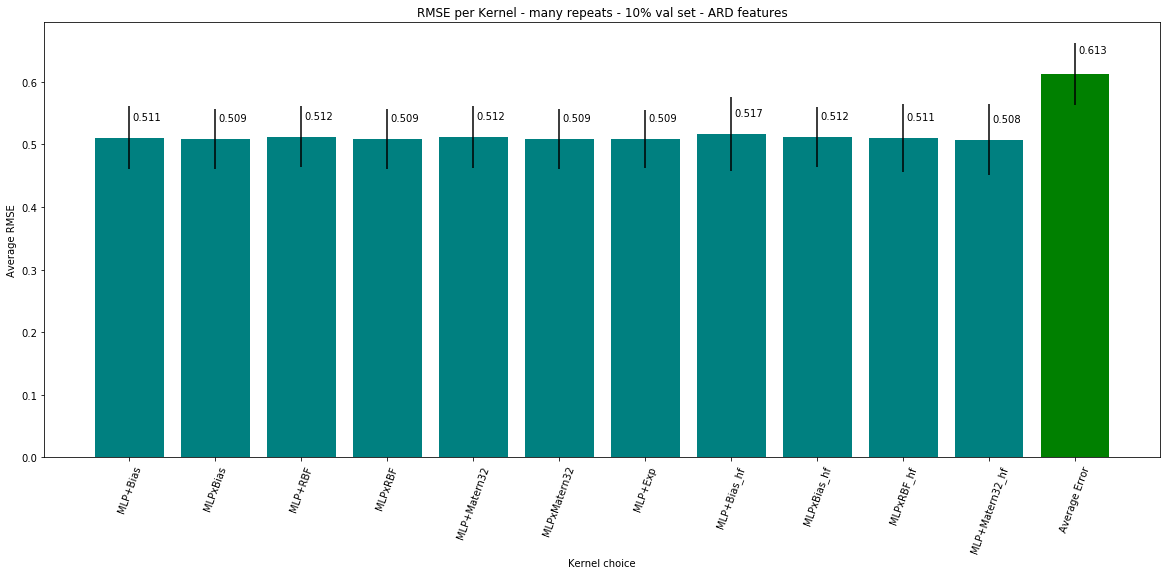

In [464]:
print "Reduce # features to: %s " % sum(abs(clf.coef_) > threshold)
(X, test, y) = data
msk = [i for i in range(X.shape[0])]
n_validation_set = int(np.floor(X.shape[0]*val_size))

RMS_reps_ard = []
for rep in xrange(10):
    print rep, 
    random.shuffle(msk)
    
    x_train_ard = X.iloc[msk[n_validation_set:]][cols].as_matrix()[:,abs(clf.coef_) > threshold]
    x_valid_ard = X.iloc[msk[:n_validation_set]][cols].as_matrix()[:,abs(clf.coef_) > threshold]
    
    y_train = y.values[msk[n_validation_set:]].reshape(x_train_ard.shape[0], 1)
    y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

    reg = xrange(0,7)
    hetro = [0, 1, 3, 4]
    RMS_reps_ard.append(evaluate_models(x_train_ard, y_train, x_valid_ard, y_valid, reg, hetro))

labels = [all_labels[j] for j in reg] + [all_labels[j]+"_hf" for j in hetro] + ["Average Error"]
plot_bars(RMS_reps_ard, 'RMSE per Kernel - many repeats - 10% val set - ARD features', labels) 


## Low Rank approximations:

10 422.048410336
20 252.10817698
30 179.521230129
40 136.755978116
50 104.814211042
60 79.0883964107
70 59.8877525801
80 43.6337369461
90 30.2896943142
100 19.5509440502
110 10.3510662054
120 2.355073081e-11


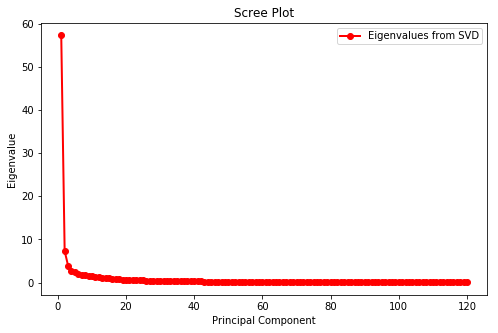

In [382]:
num_vars = x_train.shape[1]
U, S, V = np.linalg.svd(x_train, full_matrices=0)
eigvals = S # **2 / np.cumsum(S)[-1]

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3)

import sklearn.decomposition as sk_decomp

def low_rank_it(U, S, V, rank):
    return np.dot(U[:,:rank], np.dot(np.diag(S[:rank]), V[:rank,:]))
    
for i in xrange(120):
    low_rank = low_rank_it(U, S, V, i+1)
    if (i+1) %10 == 0:
        print i+1, sum(sum(np.abs(x_train - low_rank)))

In [472]:
def evaluate_low_rank(data, its = 10):
    
    (X, test, y) = data
    msk = [i for i in range(X.shape[0])]
    n_validation_set = int(np.floor(X.shape[0]*val_size))

    RMS_reps_svd = {120:[], 'random':[]}
    for rep in xrange(its):
        print rep, 
        random.shuffle(msk)
        x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
        x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()
        y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
        y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

        print "comps = ",
        for comps in xrange(0,101,20):
            if comps == 0: comps=1
            print comps,
            svd = sk_decomp.TruncatedSVD(n_components= comps)
            x_train_svd = svd.fit_transform(x_train)
            x_valid_svd = svd.transform(x_valid)
            [error, compare] = evaluate_models(x_train_svd, y_train, x_valid_svd, y_valid, [0])
            try:
                RMS_reps_svd[comps].append(error)
            except KeyError as e:
                RMS_reps_svd[comps] = [error]

        #all variables:
        print "120"
        [error, compare] = evaluate_models(x_train, y_train, x_valid, y_valid, [0])
        RMS_reps_svd[120].append(error)
        RMS_reps_svd['random'].append(compare)
    print "finished", rep
    return RMS_reps_svd

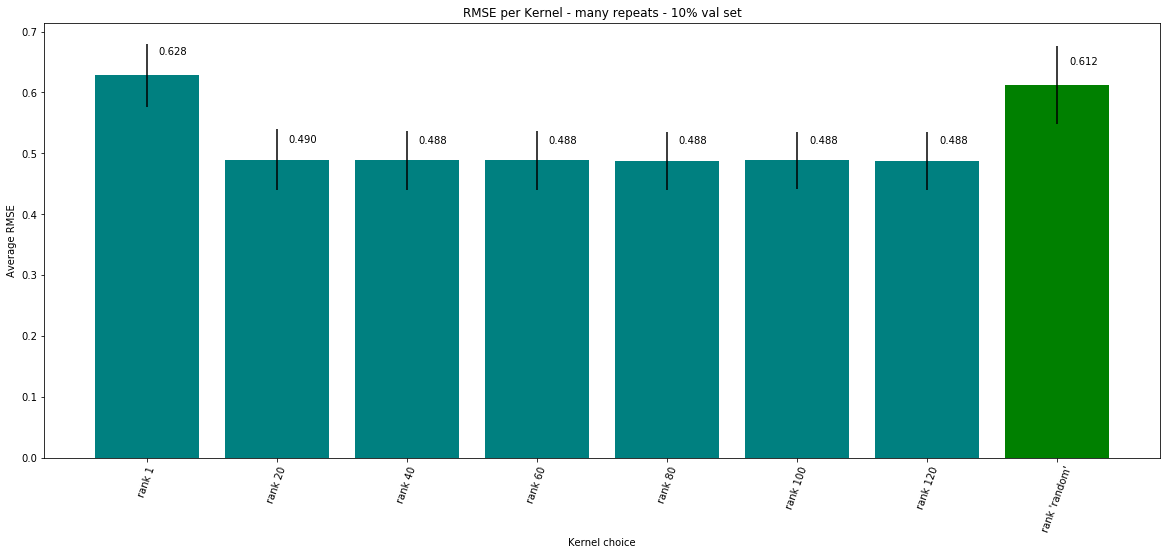

In [470]:
# RMS_reps_svd = evaluate_low_rank(data)    
RMS_reps_svd_ = np.array([j for i,j in sorted(RMS_reps_svd.items())])
labels = ["rank " + repr(i) for i,j in sorted(RMS_reps_svd.items())]

plot_bars(RMS_reps_svd_.T, 'RMSE per Kernel - many repeats - 10% val set', labels)


0 comps =  1 20 40 60 80 100 120
1 comps =  1 20 40 60 80 100 120
2 comps =  1 20 40 60 80 100 120
3 comps =  1 20 40 60 80 100 120
4 comps =  1 20 40 60 80 100 120
5 comps =  1 20 40 60 80 100 120
6 comps =  1 20 40 60 80 100 120
7 comps =  1 20 40 60 80 100 120
8 comps =  1 20 40 60 80 100 120
9 comps =  1 20 40 60 80 100 120
10 comps =  1 20 40 60 80 100 120
11 comps =  1 20 40 60 80 100 120
12 comps =  1 20 40 60 80 100 120
13 comps =  1 20 40 60 80 100 120
14 comps =  1 20 40 60 80 100 120
15 comps =  1 20 40 60 80 100 120
16 comps =  1 20 40 60 80 100 120
17 comps =  1 20 40 60 80 100 120
18 comps =  1 20 40 60 80 100 120
19 comps =  1 20 40 60 80 100 120
20 comps =  1 20 40 60 80 100 120
21 comps =  1 20 40 60 80 100 120
22 comps =  1 20 40 60 80 100 120
23 comps =  1 20 40 60 80 100 120
24 comps =  1 20 40 60 80 100 120
finished 24


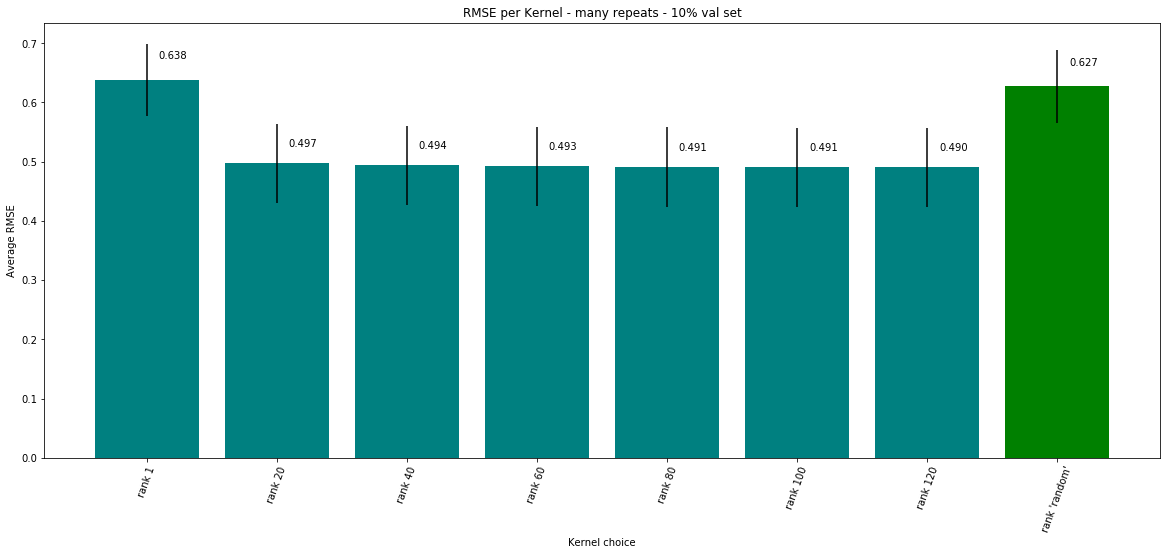

In [486]:
# Low Rank with Employment weights

RMS_reps_svd = evaluate_low_rank(data_o, 25)
RMS_reps_svd_ = np.array([j for i,j in sorted(RMS_reps_svd.items())])
labels = ["rank " + repr(i) for i,j in sorted(RMS_reps_svd.items())]

plot_bars(RMS_reps_svd_.T, 'RMSE per Kernel - many repeats - 10% val set', labels)

## Make Some Predictions:

In [487]:
# Use final model on the actual Test set of DWAs: 

(X, test, y) = data_o

x_train = X[cols].as_matrix()
y_train = y.values.reshape(x_train.shape[0], 1)
x_test = test[cols].as_matrix() #[:,abs(clf.coef_) > threshold]

# Don't need a val set:
# x_train = X.iloc[msk[n_validation_set:]][cols].as_matrix()
# x_valid = X.iloc[msk[:n_validation_set]][cols].as_matrix()
# y_train = y.values[msk[n_validation_set:]].reshape(x_train.shape[0], 1)
# y_valid = y.values[msk[:n_validation_set]].reshape(n_validation_set, 1)

llhood, models = [], []
for i in xrange(25):
    sig = random.random()
    sig_w = random.randint(0, 1000)
    in_dims = x_train.shape[1]

    k = GPy.kern.MLP(in_dims, variance = sig, weight_variance= sig_w) + GPy.kern.Bias(in_dims)
    m = GPy.models.GPRegression(x_train, y_train, k)
    m.optimize()    
    models.append(m)
    llhood.append(m.objective_function())
print llhood


[250.50582829579508, 250.51017303877742, 251.6332266551859, 250.50787208024187, 250.5106058679265, 250.51414668853727, 251.57406954395927, 250.5158516900645, 250.50639803735868, 251.71100309231448, 250.5543189888779, 250.54752396733957, 251.09983649600989, 250.51095750081305, 250.50961378455713, 250.5075695074425, 251.09880918949054, 250.5246419128298, 250.50509495081695, 250.51613324258878, 250.52132979314555, 250.5117842602868, 251.6255445906351, 250.5318089903918, 250.5160392438002]


In [488]:
best_mod = np.argmax(llhood)
m = models[best_mod]
y_pred, Vp = m.predict(x_test, full_cov=False)
# y_pred, Vp = m._raw_predict(x_test)

In [480]:
# print X.shape
# print x_train.shape
# print y_train.shape
# print x_valid.shape
# print y_valid.shape
# print x_test.shape
# print y_pred.shape
# print in_dims

# Sanity Checking output:

In [489]:
## ADD DWA and IWA titles:
DWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/DWA Reference.txt'), sep='\t')[['DWA ID', 'DWA Title']]
test2 = pd.merge(test, DWAref,  how='left', left_on=['DWA ID'], right_on = ['DWA ID'])

test2['IWA ID'] = test2['DWA ID'].str.slice(0,-4)    # create IWA ID
test2['WA ID'] = test2['DWA ID'].str.slice(0,-8)     # create WA ID

IWAref = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/IWA Reference.txt'), sep='\t')[['IWA ID', 'IWA Title']]
test2 = pd.merge(test2, IWAref,  how='left', left_on=['IWA ID'], right_on = ['IWA ID'])

WA = pd.read_table(os.path.join(datasets, 'ONET/databases/db2016/Work Activities.txt'), sep='\t')
WA.rename(columns = {'Element ID':'WA ID', 'Element Name':'WA Title'}, inplace = True)
# WA[['WA IM Value', 'WA IM SE']] = WA[['Data Value', 'Standard Error']]  # This is per Occupation. 

WA = WA[WA['Scale ID'] == "IM"][['WA ID', 'WA Title']]
WA.drop_duplicates(inplace=True)
test2 = pd.merge(test2, WA,  how='left', left_on=['WA ID'], right_on = ['WA ID'])


In [490]:
# Most and Least Automatable Inferred Task Ratings: 

number_displayed = 10

appended_list = []
for (cnt, row) in test2.iterrows():
    appended_list.append((y_pred[cnt][0], Vp[cnt][0], row['DWA ID'], row['DWA Title'], row['IWA ID'], row['IWA Title'], row['WA ID'], row['WA Title'] ))

least_dwa, most_dwa = set([]), set([])

least = [y for y in sorted(appended_list, key=lambda x: x[0])[:number_displayed]]
most = [y for y in sorted(appended_list, key=lambda x: x[0])[-number_displayed:]]

print "PREDICTED LEAST AUTOMATABLE: "
for i in [y for y in sorted(appended_list, key=lambda x: x[0])[:number_displayed]]:
    least_dwa.add(i[2][:-4])
    print "P: %0.3f of ID: %s, DWA: %s" % (i[0], i[2], i[3])

print "\nPREDICTED MOST AUTOMATABLE: "
for i in [y for y in sorted(appended_list, key=lambda x: x[0])[-number_displayed:]]:
    most_dwa.add(i[2][:-4])
    print "P: %0.3f of ID: %s, DWA: %s" % (i[0], i[2], i[3])

PREDICTED LEAST AUTOMATABLE: 
P: 1.746 of ID: 4.A.4.b.4.I09.D08, DWA: Manage organizational or program finances.
P: 1.752 of ID: 4.A.4.b.3.I02.D03, DWA: Teach social science courses at the college level.
P: 1.763 of ID: 4.A.4.b.3.I02.D11, DWA: Teach humanities courses at the college level.
P: 1.776 of ID: 4.A.2.b.2.I03.D04, DWA: Develop promotional strategies for religious organizations.
P: 1.779 of ID: 4.A.4.b.4.I07.D04, DWA: Manage human resources activities.
P: 1.786 of ID: 4.A.4.b.3.I02.D04, DWA: Lead classes or community events.
P: 1.789 of ID: 4.A.2.b.6.I01.D02, DWA: Plan conferences, programs, or special events.
P: 1.802 of ID: 4.A.4.b.3.I02.D07, DWA: Teach online courses.
P: 1.816 of ID: 4.A.2.a.1.I08.D01, DWA: Evaluate scholarly materials.
P: 1.822 of ID: 4.A.2.a.4.I09.D03, DWA: Analyze impact of legal or regulatory changes.

PREDICTED MOST AUTOMATABLE: 
P: 3.393 of ID: 4.A.1.b.2.I06.D11, DWA: Inspect items for damage or defects.
P: 3.396 of ID: 4.A.4.c.3.I03.D07, DWA: Distrib

In [491]:
# LEAST AUTOMATABLE:
# print len(set([i[3] for i in least])), " DWAs:", set([i[3] for i in least]), "\n"
print len(set([i[5] for i in least])), " IWAs:", set([i[5] for i in least]), "\n"


7  IWAs: set(['Manage budgets or finances.', 'Plan events or programs.', 'Assess characteristics or impacts of regulations or policies.', 'Manage human resources activities.', 'Teach academic or vocational subjects.', 'Evaluate scholarly work.', 'Develop business or marketing plans.']) 



In [492]:
# MOST AUTOMATABLE:
# print len(set([i[3] for i in most])), " DWAs:", set([i[3] for i in most]), "\n"
print len(set([i[5] for i in most])), " IWAs:", set([i[5] for i in most]), "\n"


8  IWAs: set(['Operate office equipment.', 'Reconcile financial data.', 'Distribute materials, supplies, or resources.', 'Stock supplies or products.', 'Execute financial transactions.', 'Determine values or prices of goods or services.', 'Maintain sales or financial records.', 'Inspect completed work or finished products.']) 



# Proposed Further: 

The above results, use the Skills, Knowledge and Abilities of Occupations. 

Genereted a feature vector per DWA by: 

- normalised Task Importance per occupation 
- normalised Task Importance per DWA 

since tasks are roughly unique to occupations. 

Then averaged the skills vectors over the DWA level. 

add: 
- NN - pyTorch. 

- remove "unsure" from survey?  
